# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [184]:
!pip install phik
!pip install imblearn
!pip install category_encoders
!pip install feature-engine
!pip install optuna
!pip install shap
!pip install scikit-learn==1.1.3

In [185]:
import pandas as pd
import numpy as np
import math
import time
import phik
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
RANDOM_STATE=12345
import category_encoders as ce

from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgbm
from sklearn.metrics import make_scorer

from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as make_imblearn_pipeline
from sklearn.metrics import mean_squared_error as mse , mean_absolute_error as mae

## Подготовка данных

### Загрузка и ознакомление с данными

In [186]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('////')
    
display(data.head()) 

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [187]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [188]:
pd.concat([data.isna().sum(), 
           data.isna().mean().apply(lambda x: '{0:.1f}%'.format(x * 100))], 
           axis=1).rename(columns={0:'Количество пропусков', 1:'Доля пропусков'})

,Количество пропусков,Доля пропусков
DateCrawled,0,0.0%
Price,0,0.0%
VehicleType,37490,10.6%
RegistrationYear,0,0.0%
Gearbox,19833,5.6%
Power,0,0.0%
Model,19705,5.6%
Kilometer,0,0.0%
RegistrationMonth,0,0.0%
FuelType,32895,9.3%


In [189]:
display(data.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
Price,354369.0000,4416.6568,4514.1585,0.0000,1050.0000,2700.0000,6400.0000,20000.0000
RegistrationYear,354369.0000,2004.2344,90.2280,1000.0000,1999.0000,2003.0000,2008.0000,9999.0000
Power,354369.0000,110.0943,189.8504,0.0000,69.0000,105.0000,143.0000,20000.0000
Kilometer,354369.0000,128211.1725,37905.3415,5000.0000,125000.0000,150000.0000,150000.0000,150000.0000
RegistrationMonth,354369.0000,5.7146,3.7264,0.0000,3.0000,6.0000,9.0000,12.0000
NumberOfPictures,354369.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
PostalCode,354369.0000,50508.6891,25783.0962,1067.0000,30165.0000,49413.0000,71083.0000,99998.0000


Не все признаки будут информативны для нашей цели, такой как дата скачивания анкеты из базы, дата создания анкеты, почтовый индекс владельца анкеты (пользователя) и дата последней активности пользователя, а также наличие фотографий. Возможно, что эти признаки могут влиять на скорость продажи машины, но не на ее рыночную стоимость. Следовательно, эти признаки можно удалить.

Также в данных содержится значительное количество пропущенных значений. В то время как для библиотеки CatBoost это не является проблемой, для более простых моделей все равно потребуется провести обработку пропущенных значений.

Помимо этого, в данных присутствуют выбросы, такие как значения лошадиных сил и года регистрации. Требуется провести анализ значений нулевого месяца регистрации, а также выполнить проверку на наличие дубликатов.

### Предобработка и исследование данных

проверяем, есть ли дубликаты

In [190]:
data.duplicated().sum()

4

In [191]:
data = data.drop_duplicates()

Проверим наличие неявных дубликатов

In [192]:
list_to_preprocessing = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']

for i in list_to_preprocessing:
    print('Уникальные значения для признака ', i) 
    print(data[i].unique())
    print('--------------------------------------------------------------------------------------------------------')

Уникальные значения для признака  VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
--------------------------------------------------------------------------------------------------------
Уникальные значения для признака  Gearbox
['manual' 'auto' nan]
--------------------------------------------------------------------------------------------------------
Уникальные значения для признака  Model
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 

дубликатов не выявлено

In [193]:
pd.concat([data.isna().sum(), 
           data.isna().mean().apply(lambda x: '{0:.1f}%'.format(x * 100))], 
           axis=1).rename(columns={0:'Количество пропусков', 1:'Доля пропусков'})

,Количество пропусков,Доля пропусков
DateCrawled,0,0.0%
Price,0,0.0%
VehicleType,37490,10.6%
RegistrationYear,0,0.0%
Gearbox,19833,5.6%
Power,0,0.0%
Model,19705,5.6%
Kilometer,0,0.0%
RegistrationMonth,0,0.0%
FuelType,32895,9.3%


#### Признак Price

Исследуем целевой признак на аномальные значения.

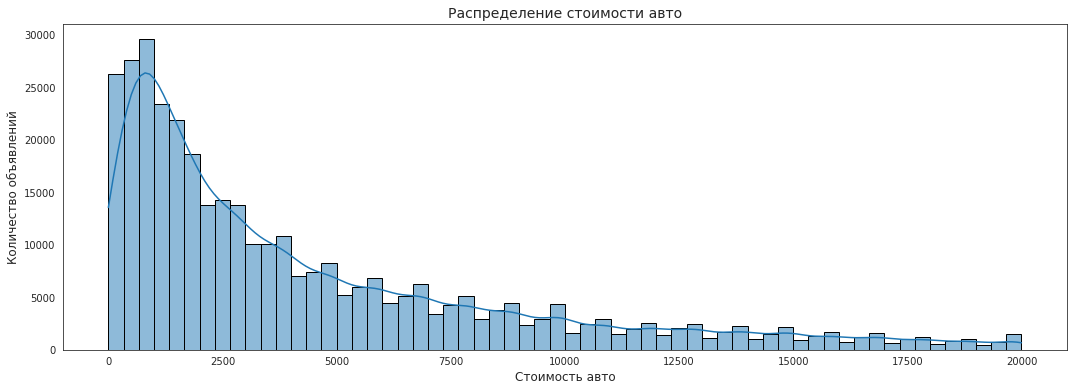

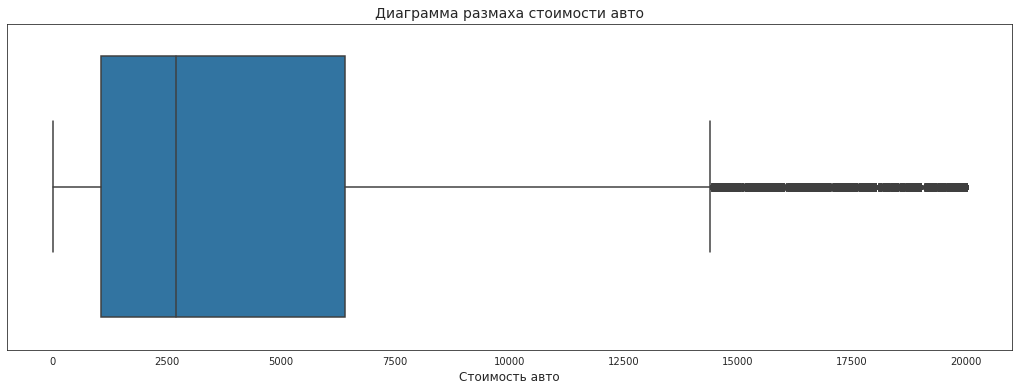

In [194]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(18,6))

sns.histplot(data=data, x='Price', kde=True, bins=60, edgecolor='black', ax=ax)
plt.title('Распределение стоимости авто', fontsize='14')
plt.xlabel('Стоимость авто', fontsize='12')
plt.ylabel('Количество объявлений', fontsize='12')
plt.show()

fig, ax = plt.subplots(figsize=(18,6))
sns.boxplot(data=data, x='Price', ax=ax)
plt.title('Диаграмма размаха стоимости авто', fontsize='14')
plt.xlabel('Стоимость авто', fontsize='12')
plt.show()

In [195]:
print('{0:.2f}%'.format(data.query("Price == 0").shape[0] / data.shape[0]))

0.03%


Таким образом, процентное соотношение значений с нулевой стоимостью составляет приблизительно 0.03%. Мы можем с уверенностью удалить эти данные, поскольку их восстановление невозможно, и они могут негативно повлиять на обучение модели.

In [196]:
data = data.drop(data.query("Price == 0").index)

Давайте также установим определенную минимальную цену, ниже которой пользователи будут устанавливать цену только в том случае, если они хотят улучшить своё положение в результатах поиска. Давайте определим её как 1-й процентиль.

In [197]:
persent = data.Price.quantile(.05)

In [198]:
print('{0:.4f}%'.format(data.query("Price < @persent").shape[0] / data.shape[0]))

0.0453%


удалим эти данные

In [199]:
data = data.drop(data.query("Price < @persent").index)

In [200]:
del persent 

#### Признак  RegistrationYear

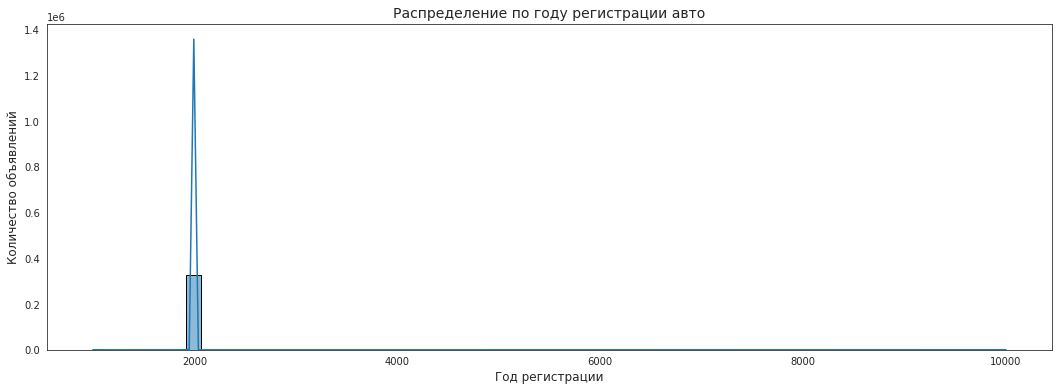

In [201]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(18,6))
sns.histplot(data=data, x='RegistrationYear', kde=True, bins=59, edgecolor='black', ax=ax)
plt.title('Распределение по году регистрации авто', fontsize='14')
plt.xlabel('Год регистрации', fontsize='12')
plt.ylabel('Количество объявлений', fontsize='12')
plt.show()
plt.show()

выявлены аномалии

Выясним какая крайняя дата анкеты в базе.

In [202]:
data.DateCrawled.max()

'2016-04-07 14:36:58'

Удалим данные с регистрацией свыше 2016г.

In [203]:
data = data.drop(data.query("RegistrationYear > 2016").index)

Посомтрим на данные с обратнйо стороны. Огарничим год регистарции 1900 и построим диаграмму размаха.

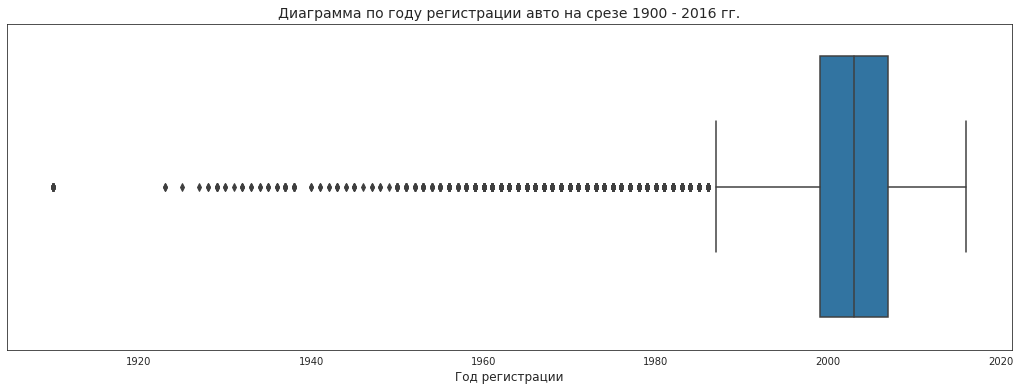

In [204]:
fig, ax = plt.subplots(figsize=(18,6))
sns.boxplot(data=data.query("RegistrationYear > 1900"), x='RegistrationYear', ax=ax)
plt.title('Диаграмма по году регистрации авто на срезе 1900 - 2016 гг.', fontsize='14')
plt.xlabel('Год регистрации', fontsize='12')
plt.show()

Ограничим срезом за 30 лет, т.е. автомобили до 1986 г.в. не будем принимать в анализ. Как видно это единичные продажи, а год 1986 как раг граничит с левым усом лиаграммы размаха.

In [205]:
print('{0:.3f}%'.format(data.query("RegistrationYear < 1986").shape[0] / data.shape[0]))

0.017%


Доля таких значенйи не велика.

In [206]:
data = data.drop(data.query("RegistrationYear < 1986").index)

Посмотрим на среднюю стоимость авто.

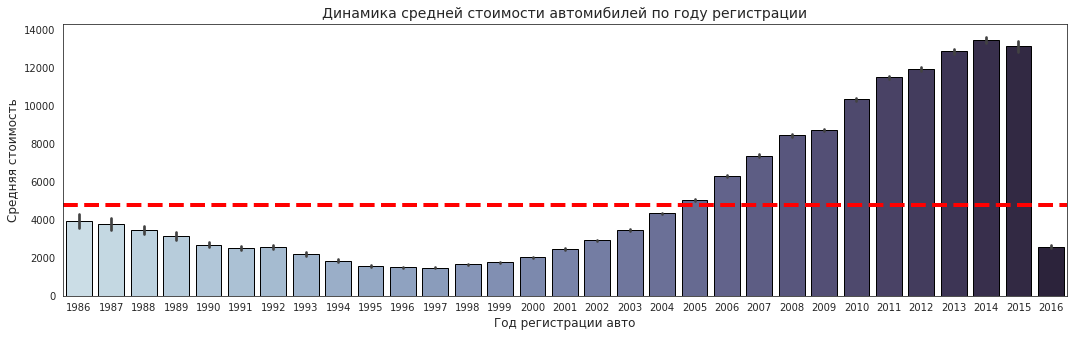

In [207]:
fig, ax = plt.subplots(figsize=(18,5))
sns.barplot(data=data, 
            x='RegistrationYear', 
            y ='Price', 
            edgecolor='black', 
            ax=ax, 
            palette=sns.color_palette('ch:s=.25,rot=-.25', 31))
plt.title('Динамика средней стоимости автомибилей по году регистрации', fontsize='14')
plt.axhline(y=data['Price'].mean(), linewidth=4, color='r', linestyle='--', label='Среднее значение', alpha=1)
plt.xlabel('Год регистрации авто', fontsize='12')
plt.ylabel('Средняя стоимость', fontsize='12')
plt.show()

выяснили зависимость цены от возраста автомобиля

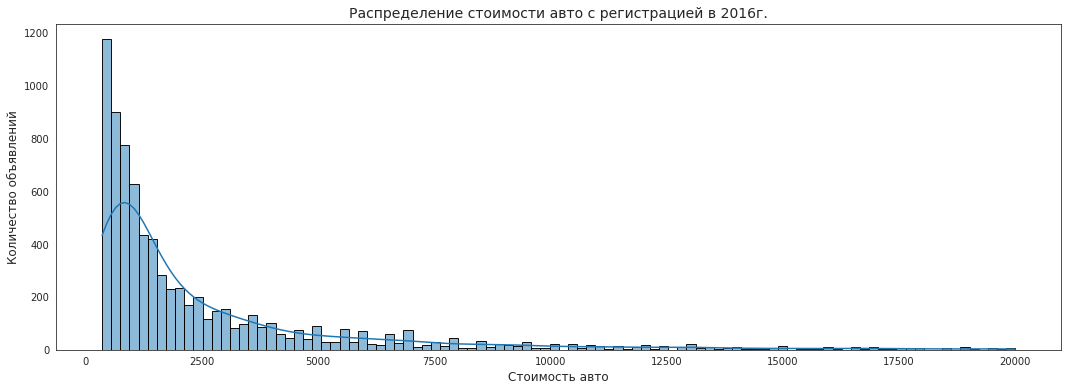

In [208]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(18,6))

sns.histplot(data=data.query("RegistrationYear == 2016"), x='Price', kde=True, bins=100, edgecolor='black', ax=ax)
plt.title('Распределение стоимости авто c регистрацией в 2016г.', fontsize='14')
plt.xlabel('Стоимость авто', fontsize='12')
plt.ylabel('Количество объявлений', fontsize='12')
plt.show()

Заметны ярко выраженные пики в диапазоне 400-800 евро. Причина этого явления не ясна. Возможно, это связано с ошибочным указанием года регистрации, либо имеются иные причины. В любом случае, мы оставим эти данные без изменений.

#### Признак RegistrationMonth

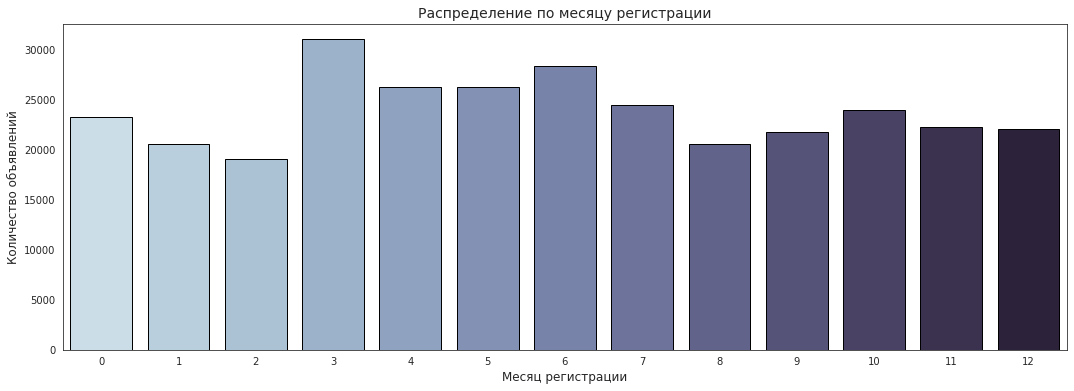

In [209]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(18,6))

sns.countplot(data=data, x='RegistrationMonth', edgecolor='black', ax=ax, palette=sns.color_palette('ch:s=.25,rot=-.25', 13))
plt.title('Распределение по месяцу регистрации', fontsize='14')
plt.xlabel('Месяц регистрации', fontsize='12')
plt.ylabel('Количество объявлений', fontsize='12')
plt.show()


In [210]:
(data.RegistrationMonth.value_counts(normalize=True))

3    0.1002
6    0.0916
4    0.0849
5    0.0847
7    0.0788
10   0.0772
0    0.0750
11   0.0717
12   0.0713
9    0.0703
8    0.0663
1    0.0663
2    0.0617
Name: RegistrationMonth, dtype: float64

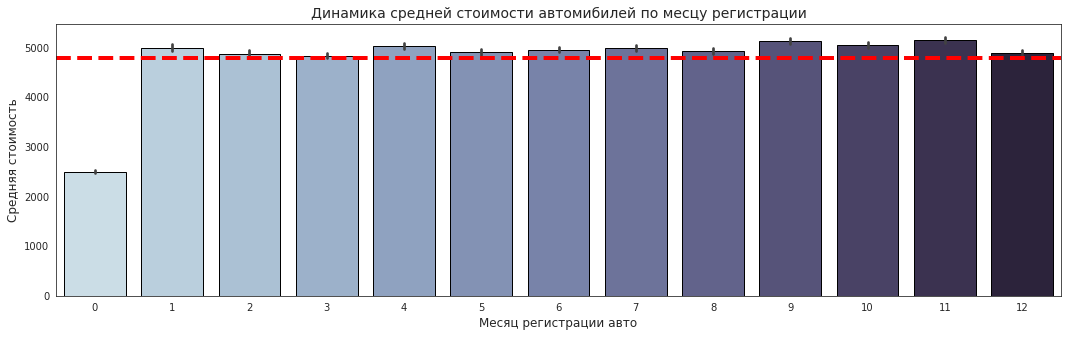

In [211]:
fig, ax = plt.subplots(figsize=(18,5))
sns.barplot(data=data, 
            x='RegistrationMonth', 
            y ='Price', 
            edgecolor='black', 
            ax=ax, 
            palette=sns.color_palette('ch:s=.25,rot=-.25', 13))
plt.title('Динамика средней стоимости автомибилей по месцу регистрации', fontsize='14')
plt.axhline(y=data['Price'].mean(), linewidth=4, color='r', linestyle='--', label='Среднее значение', alpha=1)
plt.xlabel('Месяц регистрации авто', fontsize='12')
plt.ylabel('Средняя стоимость', fontsize='12')
plt.show()

Достаточно большое количество данных содержит в графе месяц регистрации нулевой показатель. Не хотелось бы отказываться от этих данных, так как сам признак не кажется существенныы. Будем считать, что значение '0' означает unknown.
Интеренсый факт, что с 1 по 12 месяц средняя стоимость +/- одинаковая. Сильно выбиваются данные с 0 месяцем регистрации. НЕобходимо уточнить у заказчика все-таки, что означает 0-ой месяц регистрации. Учитывая, что в целом средняя стоимость в разрезе месяца регистрации одинаковая - исключим этот признак из обучения.

#### Признак DateCreated

Как уже отметили ранее сам по себе этот признак не требуется. Оданко как производная для генерации новых признаков он весьма ценен. Сначала приведем к типу данных datetime и выделим год.

In [212]:
data['DateCreated'] = (pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S.%f')).dt.year

Сгенерируем новый признаки - возраст автомобиля

In [213]:
data['age_car'] = data['DateCreated'] - data['RegistrationYear']

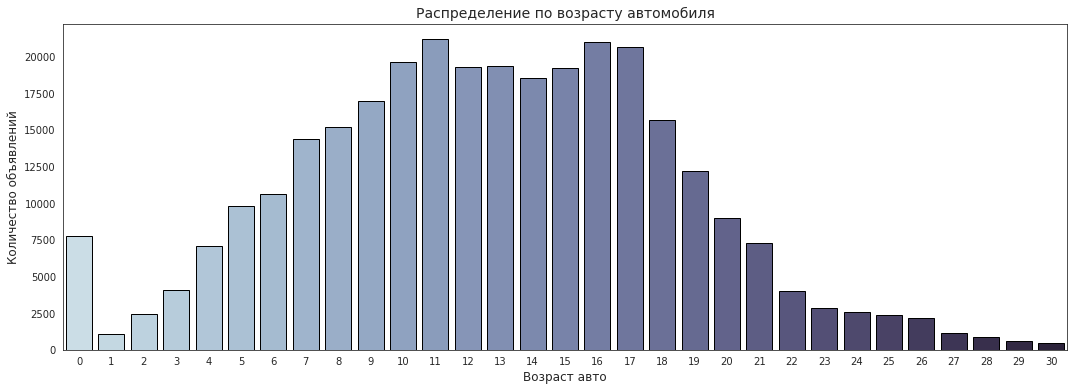

In [214]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(18,6))

sns.countplot(data=data, x='age_car', edgecolor='black', palette=sns.color_palette('ch:s=.25,rot=-.25', 31), ax=ax)
plt.title('Распределение по возрасту автомобиля', fontsize='14')
plt.xlabel('Возраст авто', fontsize='12')
plt.ylabel('Количество объявлений', fontsize='12')
plt.show()


Больше всего объявлений по автомобилям от 10 до 17 лет. После 17 лет наблюдается тенденция на снижение количества объявлений.

#### Признак Kilometer

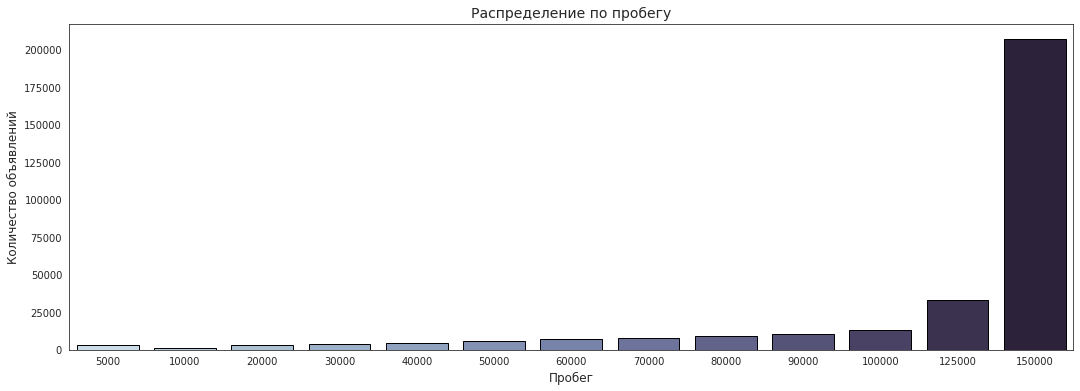

In [215]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(18,6))

sns.countplot(data=data, x='Kilometer', edgecolor='black', palette=sns.color_palette('ch:s=.25,rot=-.25', 13), ax=ax)
plt.title('Распределение по пробегу', fontsize='14')
plt.xlabel('Пробег', fontsize='12')
plt.ylabel('Количество объявлений', fontsize='12')
plt.show()

Получается в данном наборе данных показатели по пробегу не являются неприрыной величиной, а каттегоризованы с определенным шагом.Большинство объявлений с пробегом 150 тыс км., при этом болишнство объявлений с возрастом авто от 10 лет. 

#### Признак Model

На этапе выше было установлено, что для данного признака около 6% пропущенных значений. Интуитивно этот признак весьмаа важен для установления стоимости авто. Удалять или не удалять эти 6% вопрос октрытый. Попробуем протестировать с заменой на unknown.

In [216]:
data['Model'] = data['Model'].fillna('unknown')

#### Признак Repaired

Признак Repaired -наличие ремонтов также весьма важен при определении стоимости авто. Прпоусков около 20%  и уадлять такое количество данных не самый правильный подход. Корректно восстановить пропуски по имющимся данным весьма затруднительн оили в целом не возможно, поэтому запшем занчение признака в след логике:
- 0 - без ремонтов
- 1 - с ремонтами
- 2 - не известно

In [217]:
def repair_number(value):
    if value == 'no':
        return 0
    elif value == 'yes':
        return 1
    else:
        return 2

data['Repaired'] = data['Repaired'].apply(repair_number)

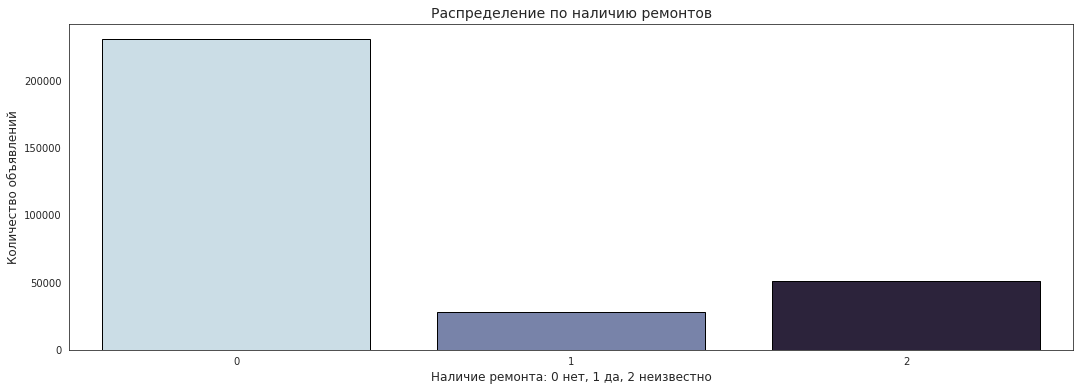

In [218]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(18,6))

sns.countplot(data=data, x='Repaired', edgecolor='black', palette=sns.color_palette('ch:s=.25,rot=-.25', 3), ax=ax)
plt.title('Распределение по наличию ремонтов', fontsize='14')
plt.xlabel('Наличие ремонта: 0 нет, 1 да, 2 неизвестно', fontsize='12')
plt.ylabel('Количество объявлений', fontsize='12')
plt.show()

Как видно большинство объявлений по автомобилям, которые не были в ремонте.

#### Признак VehicleType, Gearbox, FuelType

Данные типу кузова, коробке передач, а также типу топлива c большой вероятностью одинаковы в одинаковых моделях автомобилей. Проверим корреляцию между этими признаками, а учиытвая, что они явлются каттегориальными - воспользуемся библиотекой phik

In [219]:
list_ =['VehicleType', 'Gearbox', 'FuelType', 'Model']
data[list_].phik_matrix()

,VehicleType,Gearbox,FuelType,Model
VehicleType,1.0000,0.2861,0.3282,0.9170
Gearbox,0.2861,1.0000,0.1510,0.6386
FuelType,0.3282,0.1510,1.0000,0.5433
Model,0.9170,0.6386,0.5433,1.0000


Как и ожиадось - наблюдается уровень корреляции от среднего до выского. Заполним пропуски в данных признаках наиболее частым значением той же модели.

In [220]:
def get_fillna_with_mode(target_feature):
    data[target_feature] = data[target_feature].fillna(data
                                                       .groupby('Model')[target_feature]
                                                       .transform(lambda x: x.value_counts().idxmax())
                                                      )
    return data[target_feature]
    

data['VehicleType'] = get_fillna_with_mode('VehicleType') 
data['Gearbox'] = get_fillna_with_mode('Gearbox') 
data['FuelType'] = get_fillna_with_mode('FuelType') 

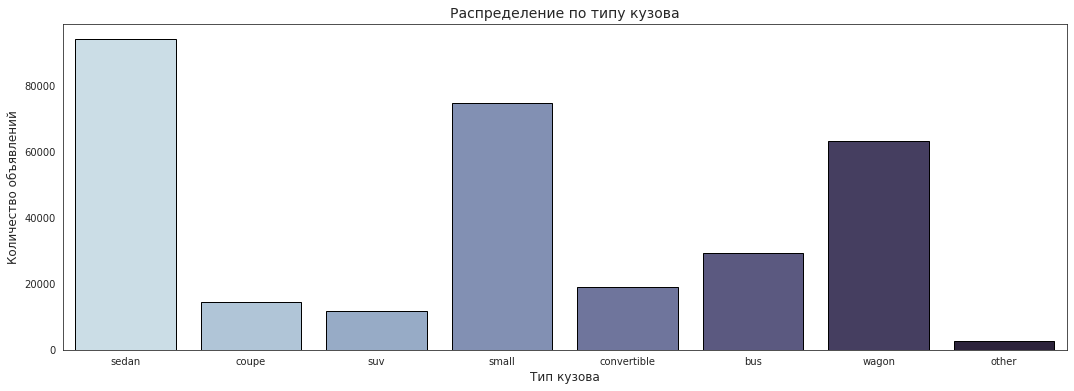

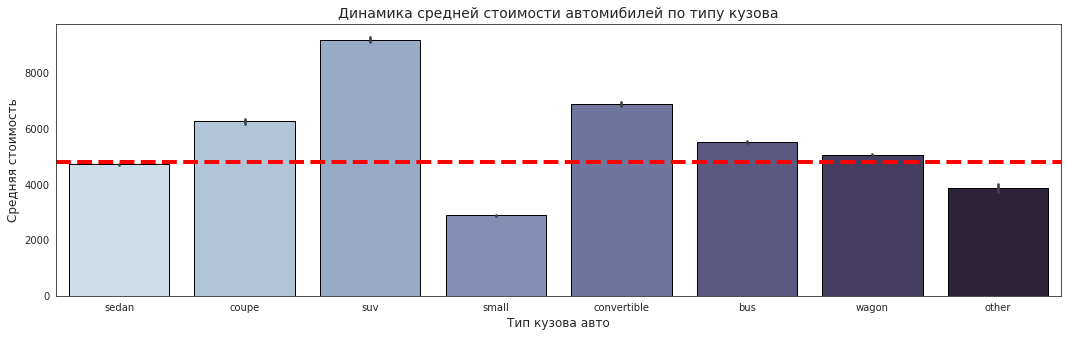

In [221]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(18,6))

sns.countplot(data=data, x='VehicleType', edgecolor='black', palette=sns.color_palette('ch:s=.25,rot=-.25', 8), ax=ax)
plt.title('Распределение по типу кузова', fontsize='14')
plt.xlabel('Тип кузова', fontsize='12')
plt.ylabel('Количество объявлений', fontsize='12')
plt.show()

fig, ax = plt.subplots(figsize=(18,5))
sns.barplot(data=data, 
            x='VehicleType', 
            y ='Price', 
            edgecolor='black', 
            ax=ax, 
            palette=sns.color_palette('ch:s=.25,rot=-.25', 8))
plt.title('Динамика средней стоимости автомибилей по типу кузова', fontsize='14')
plt.axhline(y=data['Price'].mean(), linewidth=4, color='r', linestyle='--', label='Среднее значение', alpha=1)
plt.xlabel('Тип кузова авто', fontsize='12')
plt.ylabel('Средняя стоимость', fontsize='12')
plt.show()

Наиболее популярными кузовами являются sedan при это средняя стоимость данного типа кузова сопоставима со средней стоимость по всему датасету. Чуть менее популярны small и wagon. В целом можно предположить, что тип кузова влияется на стоимость авто, а соответственно это тпризнак будет необходим для обучения.

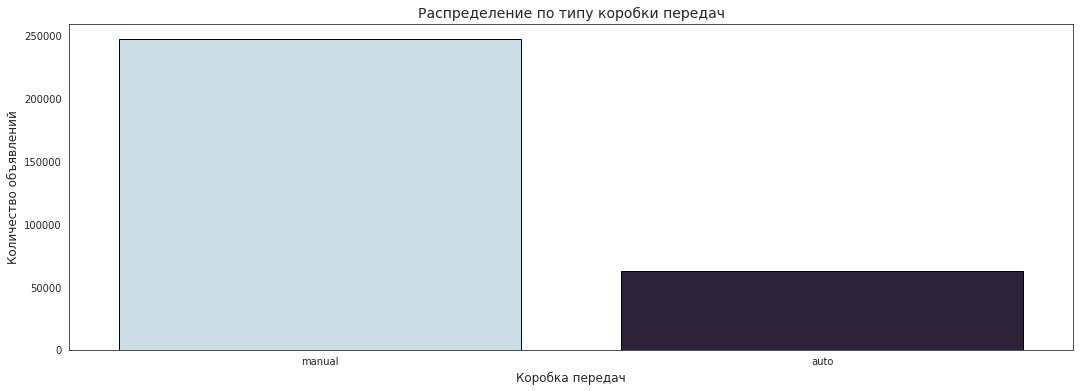

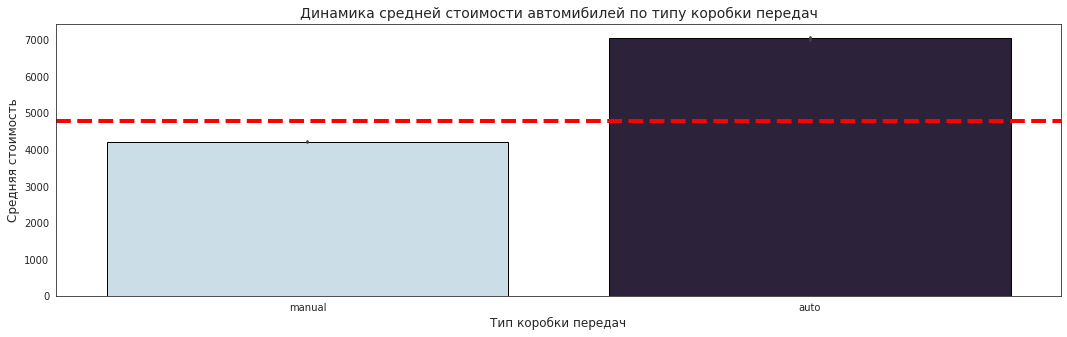

In [222]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(18,6))

sns.countplot(data=data, x='Gearbox', edgecolor='black', palette=sns.color_palette('ch:s=.25,rot=-.25', 2), ax=ax)
plt.title('Распределение по типу коробки передач', fontsize='14')
plt.xlabel('Коробка передач', fontsize='12')
plt.ylabel('Количество объявлений', fontsize='12')
plt.show()

fig, ax = plt.subplots(figsize=(18,5))
sns.barplot(data=data, 
            x='Gearbox', 
            y ='Price', 
            edgecolor='black', 
            ax=ax, 
            palette=sns.color_palette('ch:s=.25,rot=-.25', 2))
plt.title('Динамика средней стоимости автомибилей по типу коробки передач', fontsize='14')
plt.axhline(y=data['Price'].mean(), linewidth=4, color='r', linestyle='--', label='Среднее значение', alpha=1)
plt.xlabel('Тип коробки передач', fontsize='12')
plt.ylabel('Средняя стоимость', fontsize='12')
plt.show()

Интересный факт, что наиболее популярна механическая коробка передач. А вот средняя стоимость у коробки автомат выше, чме у механической. 

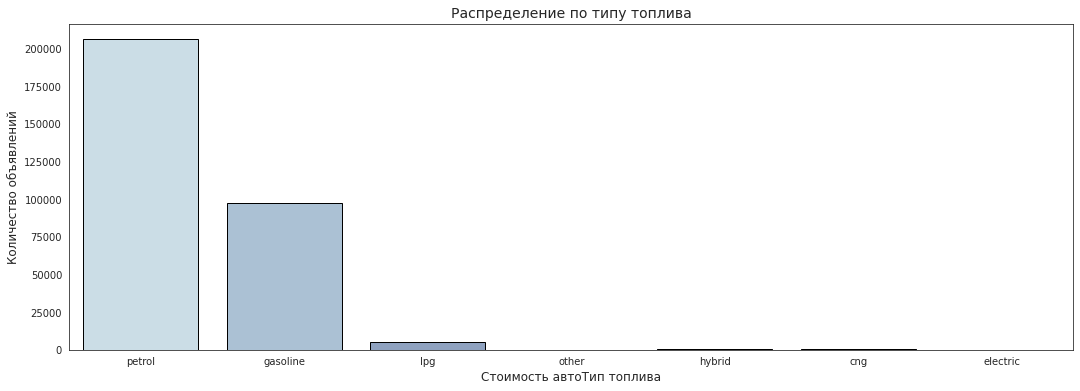

In [223]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(18,6))

sns.countplot(data=data, x='FuelType', edgecolor='black', palette=sns.color_palette('ch:s=.25,rot=-.25', 7), ax=ax)
plt.title('Распределение по типу топлива', fontsize='14')
plt.xlabel('Стоимость автоТип топлива', fontsize='12')
plt.ylabel('Количество объявлений', fontsize='12')
plt.show()


In [224]:
data.FuelType.value_counts(normalize=True)

petrol     0.6670
gasoline   0.3142
lpg        0.0159
cng        0.0017
hybrid     0.0007
other      0.0003
electric   0.0003
Name: FuelType, dtype: float64

Иходя из наблюдений выше можно сделать вывод, что около 98% приходится на безин и газ. Остальные можно объеденить в каттегорию other.

In [225]:
def get_fueltype_cat(data):
    if 'petrol' in str(data) or 'gasoline' in str(data): return data
    else: return 'other'
data['FuelType'] = data['FuelType'].apply(get_fueltype_cat)

#### Признак Power

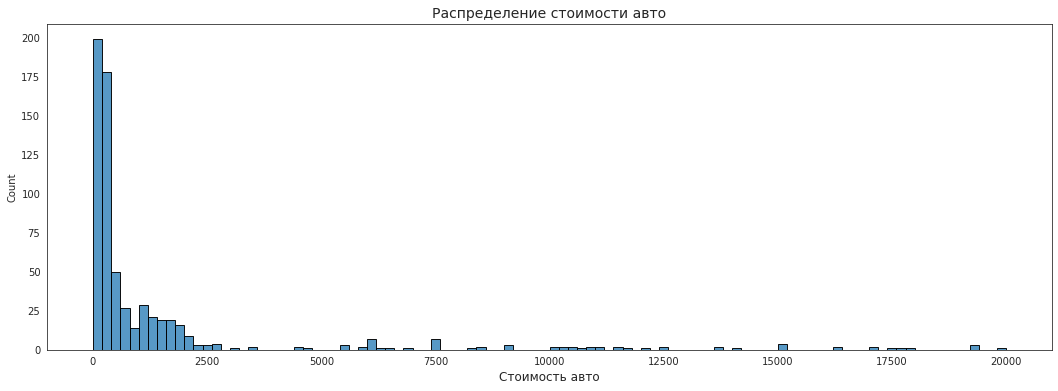

In [226]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(18,6))
sns.histplot(data=pd.Series(list(data.Power.unique())).sort_values(ascending=False),bins=100, edgecolor='black', ax=ax)
plt.title('Распределение стоимости авто', fontsize='14')
plt.xlabel('Стоимость авто', fontsize='12')
plt.show()

На распределении видится длинный хвост справа - явно аномалии. Исследуем данные детальнее. Ограничим срез до 500 л.с. Сыше 500 л.с. крайне редкие образцы.

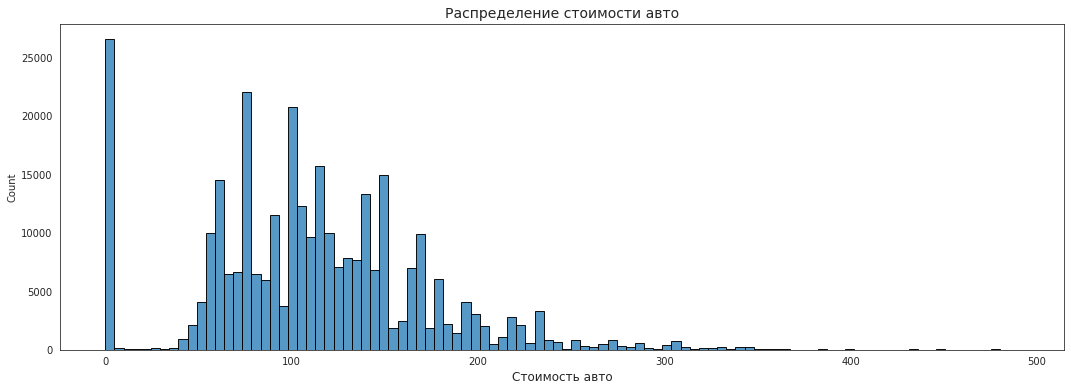

In [227]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(18,6))
sns.histplot(data.query("Power < 500"), x = 'Power', bins=100, edgecolor='black',ax=ax)
plt.title('Распределение стоимости авто', fontsize='14')
plt.xlabel('Стоимость авто', fontsize='12')
plt.show()

In [228]:
print('{0:.4f}%'.format(data.query("Power > 350").shape[0] / data.shape[0]))

0.0033%


На графике выше видно, что значения свыше 350 л.с. практически сливаются с нулем. Доля таких записей в датасете менее 1%. Можем удалить эти данные.

In [229]:
data = data.drop(data.query("Power > 350").index)

Также очень много объявленйи с нулевыми занчениями. Можно предположить, что 0 означет пропуск в данных. Необходимо заполнить нулевые значения. ПРовери корреляцию между моделью и мощностью дигателя.

In [230]:
list_ =['Power', 'Model']
data[list_].phik_matrix()

interval columns not set, guessing: ['Power']


,Power,Model
Power,1.0000,0.7949
Model,0.7949,1.0000


Корреляция высокая - заполним нулевые значения медианным значением по модели авто.

In [231]:
data.loc[data['Power'] <= 0, 'Power'] = None
data['Power'] = data['Power'].fillna(data.groupby('Model')['Power'].transform('median'))

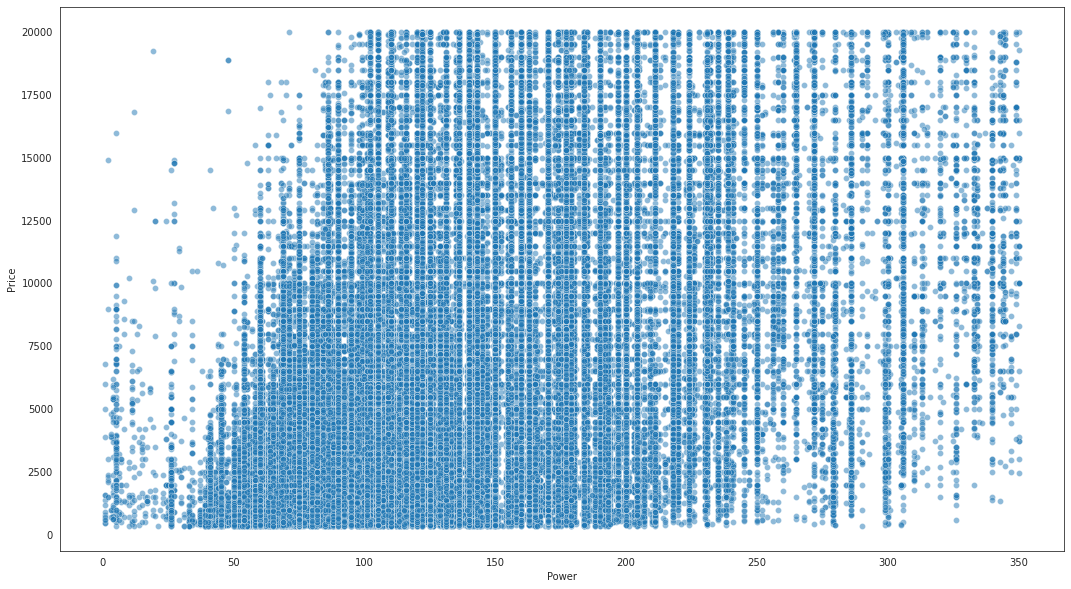

In [232]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(18,10))
sns.scatterplot(data=data, x='Power', y ='Price', alpha = 0.5)
plt.show()

В целом можно сказать, что с увеличенеим мощности двигателя растет его цена, хоть и не ярко выраженно.

Сгенерируем новый признак

In [233]:
data['log_power'] = data['Power'].apply(lambda x: math.log(x))

#### Удаление не информативных признаков.

Удалим неинформативные признаки

In [234]:
data = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'RegistrationMonth'], axis=1)

#### Исследование корреляционной зависимости 

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'Repaired', 'age_car', 'log_power']


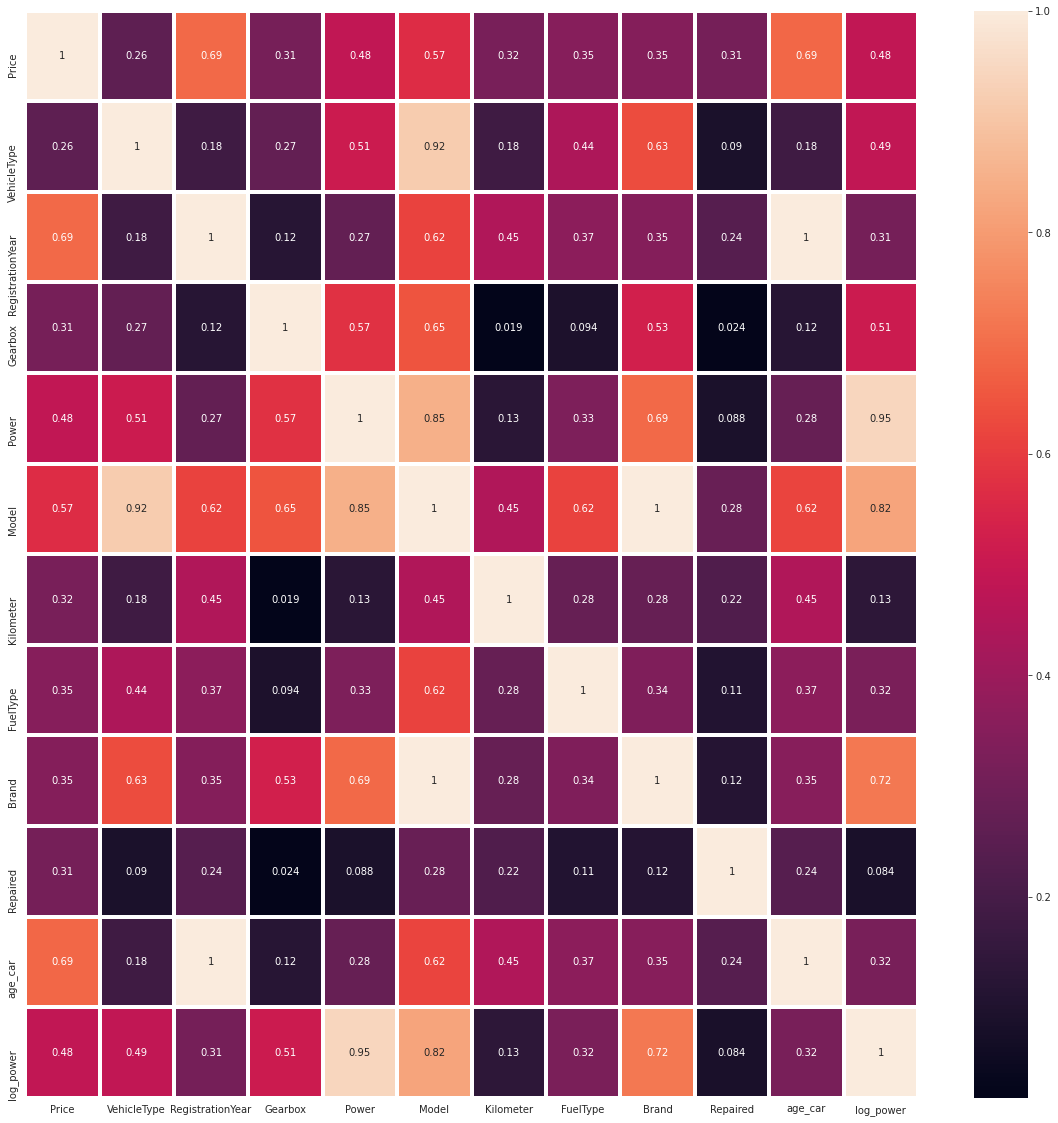

In [235]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
sns.heatmap(data.phik_matrix(), annot=True, linewidths=3, linecolor='white')
plt.show()

Наблюдается прямая завсимость между возрастом авто и годом регистрации, брендом и моделью. Предлагается удалить год регистрации и брэнд авто (корреляционная зависимость у модели с ценой выше, чем у брэнда).

In [236]:
data = data.drop(['RegistrationYear', 'Brand'], axis=1)

In [237]:
data.head()

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Repaired,age_car,log_power
0,480,sedan,manual,101.0000,golf,150000,petrol,2,23,4.6151
1,18300,coupe,manual,190.0000,unknown,125000,gasoline,1,5,5.2470
2,9800,suv,auto,163.0000,grand,125000,gasoline,2,12,5.0938
3,1500,small,manual,75.0000,golf,150000,petrol,0,15,4.3175
4,3600,small,manual,69.0000,fabia,90000,gasoline,0,8,4.2341


Выделим числовые столбцы и каттегориальные.

Как было установлено на этапе EAD - численный характер носит только признак Power и порожденный им прологарифмированный признак. Все остальные возраст авто, модель, тип топлива и даже киллометраж - каттегориальные.

In [239]:
num_cols = ['Power','log_power']
cat_cols = list(set(X.columns) - set(num_cols))

In [240]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

### Модель LinearRegression

In [241]:
num_pipeline = make_imblearn_pipeline(MinMaxScaler()) #DropCorrelatedFeatures(threshold=0.9), DropConstantFeatures()) #DropCorrelatedFeatures(threshold=0.9), DropConstantFeatures()

column_transformer = make_column_transformer((num_pipeline, num_cols),
                                             (OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_cols),
                                              remainder='passthrough')  
model = LinearRegression()
pipeline = make_pipeline(column_transformer, model)

In [242]:
start_time_fit = time.time()
rs_linearregression=pipeline.fit(X_train, y_train)

In [243]:
linear_fit_time = (time.time() - start_time_fit) / 60
start_time_predict = time.time()

In [244]:
preds_lmodel=rs_linearregression.predict(X_test)
linear_predict_time = (time.time() - start_time_predict) / 60
linear_rmse = mean_squared_error(y_test, preds_lmodel) ** 0.5

In [245]:
models_compares = {
    'LinearRegression': {
        'fit_time': round(linear_fit_time,2),
        'prediction_time': round(linear_predict_time,2),
        'rmse': round(linear_rmse,2),
    },
}
models_statistics = pd.DataFrame(models_compares).T
models_statistics 

,fit_time,prediction_time,rmse
LinearRegression,0.4600,0.0100,2011.8200


In [246]:
params = {
    'columntransformer__pipeline': [StandardScaler(), MinMaxScaler()],
    'columntransformer__onehotencoder': [OneHotEncoder(sparse=False, handle_unknown='ignore'), 
                                         ce.MEstimateEncoder()]
}

In [247]:
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Power', 'log_power']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['FuelType', 'Repaired',
                                                   'Kilometer', 'Gearbox',
                                                   'VehicleType', 'age_car',
                                                   'Model'])])),
                ('linearregression', LinearRegression())])

In [248]:
rs_linearregression_best = RandomizedSearchCV(
    pipeline,
    params,
    cv=3, 
    n_iter=20, 
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=False,
    scoring='neg_root_mean_squared_error')

In [249]:
rs_linearregression_best.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipeline',
                                                                               Pipeline(steps=[('minmaxscaler',
                                                                                                MinMaxScaler())]),
                                                                               ['Power',
                                                                                'log_power']),
                                                                              ('onehotencoder',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['FuelType',
                                                                                'Repaired',
                                                                                'Kilometer',
                                                                                'Gearbox',
                                                                                'VehicleType',
                                                                                'age_car',
                                                                                'Model'])])),
                                             ('linearregression',
                                              LinearRegression())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'columntransformer__onehotencoder': [OneHotEncoder(handle_unknown='ignore',
                                                                                           sparse=False),
                                                                             MEstimateEncoder()],
                                        'columntransformer__pipeline': [StandardScaler(),
                                                                        MinMaxScaler()]},
                   random_state=12345, scoring='neg_root_mean_squared_error',
                   verbose=False)

In [250]:
rs_linearregression_best.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline', MinMaxScaler(),
                                                  ['Power', 'log_power']),
                                                 ('onehotencoder',
                                                  MEstimateEncoder(),
                                                  ['FuelType', 'Repaired',
                                                   'Kilometer', 'Gearbox',
                                                   'VehicleType', 'age_car',
                                                   'Model'])])),
                ('linearregression', LinearRegression())])

In [251]:
best_rmse_rs = -rs_linearregression_best.best_score_
best_rmse_rs

2620.8974831783926

In [252]:
time_best_model_rs = rs_linearregression_best.refit_time_
time_best_model_rs

0.9179720878601074

In [253]:
df_results = pd.DataFrame({'Модель': ['rs_linearregression'],
                           'Время обучения (минуты)': [round(linear_fit_time,2)],
                           'Время предсказания (минуты)': [round(linear_predict_time,2)],
                           'Время обучения с подбором гиперпараметров (минуты)': [time_best_model_rs],
                           'RMSE': [round(linear_rmse,2)],
                           'RMSE c подбором гиперпараметров': [best_rmse_rs]
                           })
df_results

,Модель,Время обучения (минуты),Время предсказания (минуты),Время обучения с подбором гиперпараметров (минуты),RMSE,RMSE c подбором гиперпараметров
0,rs_linearregression,0.4600,0.0100,0.9180,2011.8200,2620.8975


### Модель Catboost

In [254]:
model_cbr = CatBoostRegressor(random_state=1234, learning_rate=0.5, verbose=False)

In [255]:
pipeline_catBoost = make_pipeline(column_transformer, model_cbr)

In [256]:
start_time_fit = time.time()
catboost=pipeline_catBoost.fit(X_train, y_train)
catboost_fit_time = (time.time() - start_time_fit) / 60

In [257]:
start_time_predict = time.time()
preds_Cmodel=catboost.predict(X_test)
catboost_predict_time = (time.time() - start_time_predict) / 60
catBoost_rmse = mean_squared_error(y_test, preds_Cmodel) ** 0.5

In [258]:
models_compares = {
    'catBoostregressor': {
        'fit_time': round(catboost_fit_time,2),
        'rmse': round(catBoost_rmse,2),
    },
}
models_statistics = pd.DataFrame(models_compares).T
models_statistics 

,fit_time,rmse
catBoostregressor,0.8800,1537.4500


In [259]:
params_catboost = {
            'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
            'depth': np.arange(2, 21,1),
            'l2_leaf_reg': np.arange(2, 21,1)
         }

In [260]:
model_catboost = CatBoostRegressor(
    cat_features = [x for x in X_train.columns if X_train[x].dtype == 'O'],
    iterations = 100,
    loss_function='RMSE',
    random_seed = RANDOM_STATE,
    verbose = False)

In [261]:
rs_catboost = RandomizedSearchCV(
    model_catboost, 
    params_catboost, 
    cv=3, 
    n_iter=10, 
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=False,
    scoring='neg_root_mean_squared_error')

In [262]:
start_time = time.time()
rs_catboost.fit(X_train, y_train)
run_time_cbr = (time.time() - start_time) / 60

In [263]:
best_rmse_cbr = -rs_catboost.best_score_

In [264]:
best_params_catboost = rs_catboost.best_params_
print('Гипермараметры для лучшего CatBoostRegressor', best_params_catboost)

Гипермараметры для лучшего CatBoostRegressor {'learning_rate': 0.4, 'l2_leaf_reg': 11, 'depth': 12}


In [265]:
time_best_model = rs_catboost.refit_time_
time_best_model

16.9004008769989

In [266]:
df_results.loc[len(df_results.index)] = ['CatBoostRegressor',
                                        round(catboost_fit_time,2),round(catboost_predict_time,2), time_best_model, catBoost_rmse, best_rmse_cbr]
df_results

,Модель,Время обучения (минуты),Время предсказания (минуты),Время обучения с подбором гиперпараметров (минуты),RMSE,RMSE c подбором гиперпараметров
0,rs_linearregression,0.4600,0.0100,0.9180,2011.8200,2620.8975
1,CatBoostRegressor,0.8800,0.0900,16.9004,1537.4519,1592.9451


### Модель LGBM (подбор гиперпараметров RandomizedSearchCV)

In [267]:
model_lgbmr = LGBMRegressor(random_state=1234, learning_rate=0.5, num_leaves=100)
pipeline_lgbmr = make_pipeline(column_transformer, model_lgbmr)
start_time_fit = time.time()
lgbmr=pipeline_lgbmr.fit(X_train, y_train)
lgbmr_fit_time = (time.time() - start_time_fit) / 60
start_time_predict = time.time()
preds_lgbmr_model=lgbmr.predict(X_test)
lgbmr_predict_time = (time.time() - start_time_predict) / 60
lgbmr_rmse = mean_squared_error(y_test, preds_lgbmr_model) ** 0.5

In [268]:
params_lgbm = {
        'lgbmregressor__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
        'lgbmregressor__n_estimators': [60, 100, 200, 300]
    }

cat_features = [x for x in X_train.columns if X_train[x].dtype == 'O']

model_lgbm = lgb.LGBMRegressor( random_state=RANDOM_STATE, boosting_type='gbdt') #, verbose=False)

column_transformer = make_column_transformer((OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), cat_features),
                                              remainder='passthrough')  
pipeline_lgbm = make_pipeline(column_transformer, model_lgbm)

rs_lgbm = RandomizedSearchCV(
    pipeline_lgbm, 
    params_lgbm, 
    cv=3, 
    n_iter=5, 
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=False,
    scoring='neg_root_mean_squared_error')

In [269]:
start_time = time.time()
rs_lgbm.fit(X_train, y_train)
run_time_lgbm = (time.time() - start_time) / 60

In [270]:
best_rmse_lgbm = -rs_lgbm.best_score_

In [271]:
df_results.loc[len(df_results.index)] = ['LGBMRegressor',lgbmr_fit_time, run_time_lgbm,lgbmr_predict_time,
                                        lgbmr_rmse,best_rmse_lgbm ]

In [272]:
df_results

,Модель,Время обучения (минуты),Время предсказания (минуты),Время обучения с подбором гиперпараметров (минуты),RMSE,RMSE c подбором гиперпараметров
0,rs_linearregression,0.4600,0.0100,0.9180,2011.8200,2620.8975
1,CatBoostRegressor,0.8800,0.0900,16.9004,1537.4519,1592.9451
2,LGBMRegressor,0.2256,1.3963,0.0150,1567.2180,1564.2127


In [273]:
best_catboost_model = rs_catboost.best_estimator_

## Анализ моделей

In [274]:
def rmse(test,predict):
    return ((mse(test,predict))**0.5).round(2)

In [275]:
start_time = time.time()
predict_catboost = best_catboost_model.predict(X_test)
run_time = (time.time() - start_time) / 60

In [276]:
catboost_best_rmse = rmse(y_test, predict_catboost)

In [277]:
df_results = pd.DataFrame({'Модель': ['Catboost'], 
                           'RMSE': [catboost_best_rmse],
                           'Время предсказания (минуты)': [run_time]})

In [278]:
df_results

,Модель,RMSE,Время предсказания (минуты)
0,Catboost,1576.3200,0.0016


**Вывод**
Для оценки качества моделей использовалась метрика RMSE, значение которой должно быть менее 2500. Цель проекта состоит в построении модели для определения стоимости автомобиля с наилучшими показателями качества предсказания, скорости и времени обучения. Чем ниже значение RMSE, тем лучше модель может соответствовать набору данных. Технология градиентного бустинга была сравнена с линейной моделью RidgeRegression. В результате обучения моделей CatBoostRegressor продемонстрировала более высокое качество по метрике RMSE и более эффективное время обучения по сравнению с другими рассмотренными моделями.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей